Practice geospatial aggregations in geopandas before writing them to .py files

In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('../utils')
import wd_management
wd_management.set_wd_root()

In [19]:
import geopandas as gp
import pandas as pd
import requests

In [ ]:
res = requests.get('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Public_Use_Microdata_Areas_PUMAs_2010/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')
res_json = res.json()

In [21]:
gp.read_file(res_json)

AttributeError: 'dict' object has no attribute 'startswith'

In [12]:
nyc_url ='https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Public_Use_Microdata_Areas_PUMAs_2010/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
PUMAs = gp.read_file('resources/PUMA_2010_clipped_shp.zip')
PUMAs.to_crs('EPSG:4326',inplace=True)

DriverError: '/vsizip/resources/PUMA_2010_clipped_shp.zip' not recognized as a supported file format.

<AxesSubplot:>

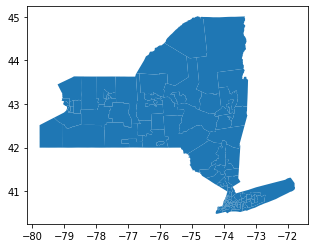

In [8]:
PUMAs.plot()

In [6]:
PUMAs.head(5)

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,01206,3601206,Erie County (West Central)--Buffalo City (West...,G6120,S,35054334,3061084,+42.9297846,-078.8825397,"POLYGON ((-78.90371 42.96279, -78.90328 42.963..."
1,36,01801,3601801,Saratoga County (South & Central) PUMA,G6120,S,339825377,20756345,+42.9416254,-073.7850807,"POLYGON ((-73.69767 42.77873, -73.69776 42.778..."
2,36,03104,3603104,Westchester County (Southeast) PUMA,G6120,S,93723582,58589232,+40.9727205,-073.7059099,"POLYGON ((-73.72474 41.01554, -73.72453 41.015..."
3,36,03106,3603106,Westchester County (Southwest)--Yonkers City PUMA,G6120,S,46650851,5916862,+40.9458622,-073.8674464,"POLYGON ((-73.87819 40.90598, -73.87822 40.905..."
4,36,03202,3603202,Nassau County (Northeast)--Oyster Bay Town (No...,G6120,S,173559725,141536924,+40.8821864,-073.5589406,"POLYGON ((-73.64192 40.82535, -73.64307 40.826..."


Get nyc PUMAs. Use code copied from PUMS query manager. Coumn in geodataframe with PUMA id is PUMACE10. This column has leading 0

In [7]:
geo_ids = [
        range(4001, 4019),  # Brooklyn
        range(3701, 3711),  # Bronx
        range(4101, 4115),  # Queens
        range(3901, 3904),  # Staten Island
        range(3801, 3811),  # Manhattan
]
NYC_PUMA_ids = []
for b in geo_ids:
    for PUMA in b:
        NYC_PUMA_ids.append(PUMA)

In [8]:
PUMAs.loc[:,'PUMA'] = PUMAs['PUMACE10'].str[1:].astype(int)
PUMAs

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,PUMA
0,36,01206,3601206,Erie County (West Central)--Buffalo City (West...,G6120,S,35054334,3061084,+42.9297846,-078.8825397,"POLYGON ((-78.90371 42.96279, -78.90328 42.963...",1206
1,36,01801,3601801,Saratoga County (South & Central) PUMA,G6120,S,339825377,20756345,+42.9416254,-073.7850807,"POLYGON ((-73.69767 42.77873, -73.69776 42.778...",1801
2,36,03104,3603104,Westchester County (Southeast) PUMA,G6120,S,93723582,58589232,+40.9727205,-073.7059099,"POLYGON ((-73.72474 41.01554, -73.72453 41.015...",3104
3,36,03106,3603106,Westchester County (Southwest)--Yonkers City PUMA,G6120,S,46650851,5916862,+40.9458622,-073.8674464,"POLYGON ((-73.87819 40.90598, -73.87822 40.905...",3106
4,36,03202,3603202,Nassau County (Northeast)--Oyster Bay Town (No...,G6120,S,173559725,141536924,+40.8821864,-073.5589406,"POLYGON ((-73.64192 40.82535, -73.64307 40.826...",3202
...,...,...,...,...,...,...,...,...,...,...,...,...
140,36,04101,3604101,NYC-Queens Community District 1--Astoria & Lon...,G6120,S,13227962,1655745,+40.7710111,-073.9154006,"POLYGON ((-73.92442 40.75240, -73.92563 40.752...",4101
141,36,04102,3604102,NYC-Queens Community District 3--Jackson Heigh...,G6120,S,10527056,2455010,+40.7650278,-073.8752395,"POLYGON ((-73.87463 40.74861, -73.87549 40.748...",4102
142,36,04109,3604109,NYC-Queens Community District 2--Sunnyside & W...,G6120,S,15468354,459087,+40.7403915,-073.9206747,"POLYGON ((-73.92442 40.75240, -73.92297 40.752...",4109
143,36,01400,3601400,Ontario & Yates Counties PUMA,G6120,S,2543907549,145318940,+42.7700574,-077.2425160,"POLYGON ((-76.96336 42.87713, -76.96336 42.877...",1400


<AxesSubplot:>

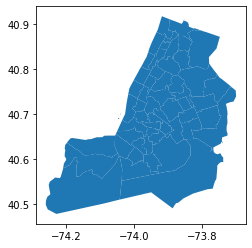

In [9]:
NYC_PUMAs = PUMAs[PUMAs['PUMA'].isin(NYC_PUMA_ids)]
NYC_PUMAs.set_index('PUMA',inplace=True)
NYC_PUMAs.plot()

Ok looks good. Load in historic districts. [This stackoverflow post](https://gis.stackexchange.com/questions/327197/typeerror-input-geometry-column-must-contain-valid-geometry-objects) was helpful 

In [18]:
from shapely import wkt

In [158]:
hd= gp.read_file('.library/lpc_historic_district_areas/20210712/lpc_historic_district_areas.csv')
hd['the_geom'] = hd['the_geom'].apply(wkt.loads)
hd.set_geometry(col='the_geom', inplace=True, crs='EPSG:4326')

<AxesSubplot:>

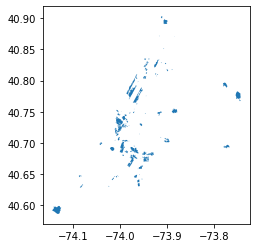

In [159]:
hd= hd.explode(column='the_geom')
hd.set_geometry('the_geom',inplace=True)
hd = hd.reset_index()
hd.plot()

Ok great next do some geospatial analysis. Start only with PUMA 3807 as it has a lot of historic area

In [160]:
import warnings
warnings.filterwarnings("ignore")

In [167]:
def fraction_area_historic(PUMA, hd):
    try:
        gdf = gp.GeoDataFrame(geometry = [PUMA.geometry])
        overlay = gp.overlay( hd, gdf, 'intersection')
        if overlay.empty:
            return 0
        else:
             rv =overlay.area.sum()/PUMA.geometry.area
        return rv
    except Exception as e:
        print(f'broke on {PUMA}')
        print(e)


In [170]:
NYC_PUMAs['fraction_area_historic'] = NYC_PUMAs.apply(fraction_area_historic, axis=1, args=(hd,))

In [172]:
NYC_PUMAs.sort_values('fraction_area_historic', ascending=False)

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,fraction_historic,fraction_area_historic
PUMA,,,,,,,,,,,,,
4004,36,04004,3604004,NYC-Brooklyn Community District 2--Brooklyn He...,G6120,S,8048802,372201,+40.6914104,-073.9759312,"POLYGON ((-73.99779 40.69119, -73.99848 40.691...",None,0.209535
4006,36,04006,3604006,NYC-Brooklyn Community District 8--Crown Heigh...,G6120,S,5758114,0,+40.6749896,-073.9440010,"POLYGON ((-73.94773 40.66971, -73.95050 40.669...",None,0.192580
3810,36,03810,3603810,NYC-Manhattan Community District 1 & 2--Batter...,G6120,S,7679677,7163465,+40.7116648,-074.0124167,"MULTIPOLYGON (((-74.03940 40.70047, -74.03833 ...",None,0.187684
3806,36,03806,3603806,NYC-Manhattan Community District 7--Upper West...,G6120,S,7643534,2849208,+40.7854533,-073.9747869,"POLYGON ((-73.98251 40.80071, -73.98058 40.803...",None,0.164112
3805,36,03805,3603805,NYC-Manhattan Community District 8--Upper East...,G6120,S,5226559,1642907,+40.7702321,-073.9527550,"POLYGON ((-73.96936 40.76927, -73.96890 40.769...",None,0.153833
3803,36,03803,3603803,NYC-Manhattan Community District 10--Central H...,G6120,S,3747589,222570,+40.8137240,-073.9429990,"POLYGON ((-73.95588 40.80880, -73.95543 40.809...",None,0.081897
4003,36,04003,3604003,NYC-Brooklyn Community District 3--Bedford-Stu...,G6120,S,5949105,0,+40.6898697,-073.9410682,"POLYGON ((-73.91797 40.67867, -73.91905 40.678...",None,0.079206
3708,36,03708,3603708,"NYC-Bronx Community District 4--Concourse, Hig...",G6120,S,5140918,3019,+40.8325863,-073.9214409,"POLYGON ((-73.90598 40.83850, -73.90694 40.836...",None,0.074335
4005,36,04005,3604005,"NYC-Brooklyn Community District 6--Park Slope,...",G6120,S,10369361,5922074,+40.6719366,-074.0020800,"POLYGON ((-73.98017 40.66116, -73.98223 40.662...",None,0.071465


Surprised by these numbers, from eyeballing map is does look like 3810 should have the most of it's area in a historic district. Looks like more than 20% of 3801 is historic. Analysis may be off but at least I have process and have worked out all difficulties of geopandas